In [1]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import glob
import cv2
import os

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'Colab Notebooks/CCS Prediction/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

import align_ccs
import keras


Mounted at /content/drive


In [2]:
model = keras.models.load_model('/content/drive/My Drive/Colab Notebooks/CCS Prediction')

In [3]:
def string_vectorizer(strng, alphabet='ARNDCQEGHILKMFPSTWYV'):
    vector = [[0 if char != letter else 1 for char in alphabet] 
                  for letter in strng]
    return vector

In [4]:
test_path = '/content/drive/My Drive/Colab Notebooks/CCS Prediction/Data/'

# insert file name for test data below
testname = 'Mouse FDR1'
Tdata = pd.read_csv(test_path + testname + '.csv')

Tseq = Tdata["Sequence"]
Tattributes = Tdata["Charge"]
Tlabel = Tdata["CCS"]

Tarray = np.array(Tseq)
Tlen = np.shape(Tarray)[0]
Tseq_feat = [[]]
for i in range(0,Tlen):
    Tarray[i] = Tarray[i].ljust(60,'*')
    Tseq_feat.append(np.reshape(string_vectorizer(Tarray[i]),1200, order = 'F'))
Tseq_feat.pop(0)

Tseq = np.array(Tseq_feat)
Tattribute = np.array(Tattributes)
TY = np.array(Tlabel)

print("[INFO] predicting ion mobiliities...")
Tpreds = model.predict([Tseq, Tattribute])

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (59) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[INFO] predicting ion mobiliities...


In [5]:
# Align CCS with training data 
filename = 'Training data'
Source = pd.read_csv(test_path + filename + '.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (67) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


/content/drive/My Drive/Colab Notebooks/CCS Prediction/align_ccs.py:15: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  data = data.set_index('Sequence').T.to_dict('series')
/content/drive/My Drive/Colab Notebooks/CCS Prediction/align_ccs.py:17: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  test = test.set_index('Sequence').T.to_dict('series')


-14.179623499163615
1946


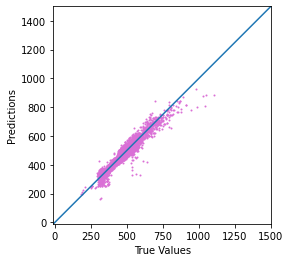

In [6]:
Tpreds = Tpreds.flatten()
shift = align_ccs.findshift(Tdata, Source)
if shift <= 0:
  Tpreds = Tpreds + shift
else:
  Tpreds = Tpreds - shift
a = plt.axes(aspect='equal')
plt.scatter(TY, Tpreds, s = 1, c='orchid')
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [-10, 1500]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

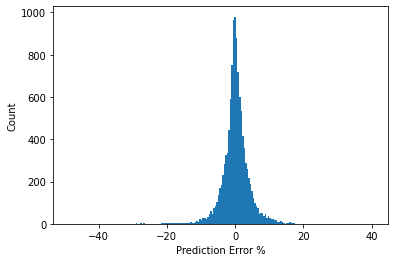

In [7]:
Terror = (Tpreds - TY)/TY*100
# Terror = (Tpreds - TY)
plt.hist(Terror, bins=200)
plt.xlabel('Prediction Error %')
# plt.xlim([-100,100])
_ = plt.ylabel('Count')

In [8]:
from scipy import stats
Test = stats.pearsonr(TY,Tpreds)
print('Unseen data:' + str(Test[0]))

Unseen data:0.9734291691725678


In [9]:
(np.absolute(Terror) < 10).sum()/np.shape(Terror)[0]

0.9695422687548672